# Homework 4: Applied ML


> We will work with a by-now classic dataset from Robert LaLonde's study "Evaluating the Econometric Evaluations of Training Programs" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Your task is to determine the effectiveness of the "treatment" represented by the job training program.

We first import all the packages needed here and define plotting functions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nt
import multiprocessing as mp
from scipy.optimize import linear_sum_assignment
from sklearn import linear_model

In [56]:
def display(f):
    raise Error()

#This function displays a combination of a histogram of the data and a density function we could associate to it.
def densplot(columns, xlabel, title, axo):
    for i,v in enumerate(columns):
        sns.distplot(v, ax=axo, kde_kws={"label": i})
    axo.set_title(title, size=16)
    axo.set_xlabel(xlabel, fontsize=12)

    
#This function displays a boxplot of the data according to quantils if the violin value is set to False 
#and a violin plot otherwise
def boplot(data, title, xlabel, ylabel, violin, axo): #violin=True means a quantil plot
    if violin:
        sns.violinplot(data=data, ax=axo)
    else:
        sns.boxplot(data=data, ax=axo)
    axo.set_title(title, size=16)
    axo.set_xlabel(xlabel, fontsize=12)
    axo.set_ylabel(ylabel, fontsize=12)

#This function displays a bar chart of the different categories contained in data
def valCountBar(data, title, xlabel, ylabel, axo, color):
    colors = {"b":"#3274A1", "r":"#E1812C"}
    data.value_counts().plot(kind='bar', ax=axo, color=colors[color])
    axo.set_title(title, size=16)
    axo.set_xlabel(xlabel, fontsize=12)
    axo.set_ylabel(ylabel, fontsize=12)

We recall the dataset description and proceed to import it.

> #### Dataset description
> - `treat`: 1 if the subject participated in the job training program, 0 otherwise
> - `age`: the subject's age
> - `educ`: years of education
> - `race`: categorical variable with three possible values: Black, Hispanic, or White
> - `married`: 1 if the subject was married at the time of the training program, 0 otherwise
> - `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
> - `re74`: real earnings in 1974 (pre-treatment)
> - `re75`: real earnings in 1975 (pre-treatment)
> - `re78`: real earnings in 1978 (outcome)

In [45]:
data = pd.read_csv('lalonde.csv', index_col=0)
data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


To match with the description and for simplicity in future steps, we create the `race` and `white` columns:

In [46]:
# Check that there is no black AND hispanic in the dataset
print("Number of black hispanic people: ", len(data.loc[(data['black'] == 1) & (data['hispan'] == 1)]))

# Sets the categorical "race" attribute
data["race"] = "white"
data.loc[data['black'] == 1,'race'] = "black"
data.loc[data['hispan'] == 1,'race'] = "hispanic"

# Create a dummy "white" feature
data["white"] = 0
data.loc[(data['black'] == 0) & (data['hispan'] == 0),'white'] = 1

data.head(10)

Number of black hispanic people:  0


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race,white
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,black,0
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,hispanic,0
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,black,0
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,black,0
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,black,0
NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,black,0
NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,black,0
NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,black,0
NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,black,0


### 1. A naive analysis

In this part, we compare the mean and distribution of the outcome variable (`re78`) between the two groups (control and test)

In [50]:
grouped = data.groupby('treat')
grouped0 = grouped.get_group(0)
grouped1 = grouped.get_group(1)

**What might a naive "researcher" conclude from this superficial analysis?**

We perform some basic (naive) analysis on the data.

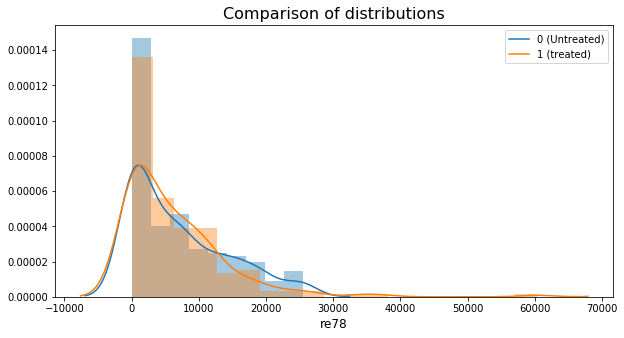

Average outcome salary of untreated 6984.16974231
Average outcome salary of treated 6349.14353027


In [57]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(10,5))
densplot([grouped0['re78'],grouped1['re78']], "re78", "Comparison of distributions", ax1)
ax1.legend(["0 (Untreated)", "1 (treated)"])
plt.show()
print("Average outcome salary of untreated", grouped0['re78'].mean())
print("Average outcome salary of treated", grouped1['re78'].mean())

A very naive observer that only compares the average salaries could think that the program has a negative effect, as the average salaray is lower for those who followed the program.

A little less naive observer would think that the two distributions are pretty similar even though there seems to be more people that didn't follow the program with an income between 1500 and 2000.


/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


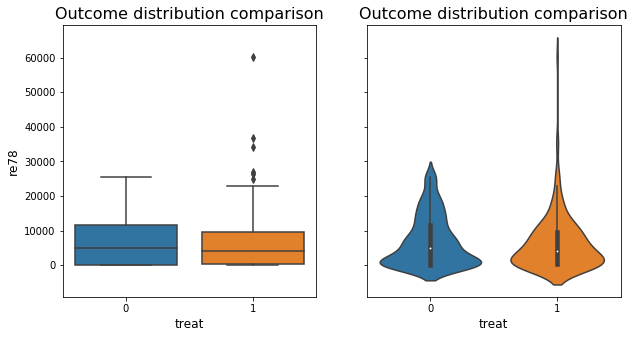

In [55]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
boplot([grouped0['re78'],grouped1['re78']],"Outcome distribution comparison", "treat", "re78", False, ax1)
boplot([grouped0['re78'],grouped1['re78']],"Outcome distribution comparison", "treat", "", True, ax2)
plt.show()

The boxplot and violin plot (combination of boxplot and kernel density estimate) tend to show the same as we observed previously. Nevertheless, they also show that the group that followed the program contains more outliers, or in other words, more people with (much) higher incomes.

*A naive conclusion would be to say that the program is not very efficient except for a few people that have a very high income*

### 2. A closer look at the data

For each feature in the dataset, we compare its distribution in the treated group with its distribution in the control group. 
Since each feature is pretty different, we cannot plot everything at the same time and we will do each feature at a time.

#### Age

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


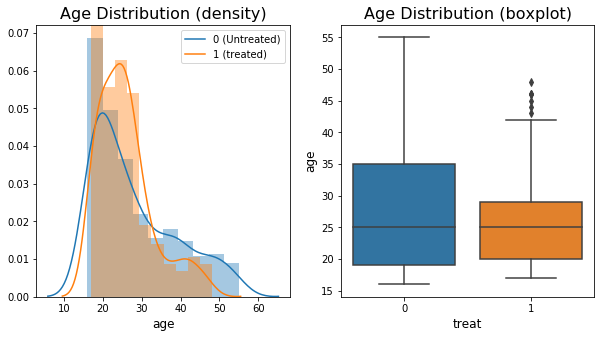

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10,5))
densplot([grouped0["age"],grouped1["age"]], "age", "Age Distribution (density)", ax1)
ax1.legend(["0 (Untreated)", "1 (treated)"])
boplot([grouped0["age"],grouped1["age"]],"Age Distribution (boxplot)", "treat", "age", False, ax2)
plt.show()

We observe that even if the median is similar in both datasets according to the age feature, the control group contains more older people while the people that followed the program were concentrated in the 20 to 30 years old age range.

*A first observation that we can do, is that the income is often related to the age, as more experience usually mean a better income. Thus, the fact that the two datasets have different age distribution should be considered in the comparison*

#### Education

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


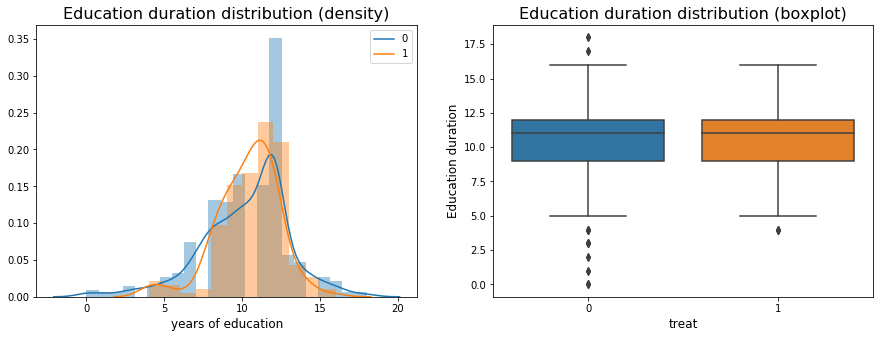

In [59]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))
ax1.legend(["0 (Untreated)", "1 (treated)"])
densplot([grouped0["educ"],grouped1["educ"]], "years of education", "Education duration distribution (density)", ax1)
boplot([grouped0["educ"],grouped1["educ"]],"Education duration distribution (boxplot)", "treat", "Education duration", False, ax2)
plt.show()

We see that in terms of education duration, the values are more spread in the control group  with outliers in both direction (with few or many years of education). Again the median is similar in both datasets but we observe that this feature is more concentrated on a slightly smaller range of values in the treated group, and more spread and sparse in the control one.

#### Race

We now observe the "race" feature that we built from the "black" and "hispan" features at the beginning

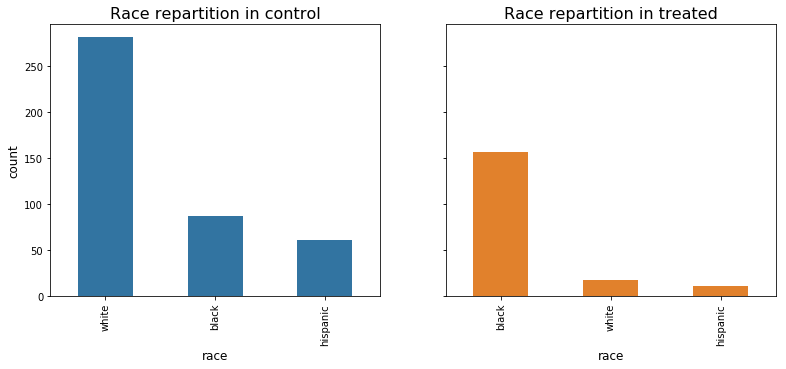

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(13,5))
valCountBar(grouped0['race'], "Race repartition in control", "race", "count", ax1, 'b')
valCountBar(grouped1['race'], "Race repartition in treated", "race", "count", ax2, 'r')
plt.show()

In this case, we do not need more plots to see that the people that didn't follow the program were mostly white, while the treated group contained more black people.

*Again, it might well be that, sadly, the average income for black people was usually lower than for white people which can also interfere with the results of the study*

#### Married

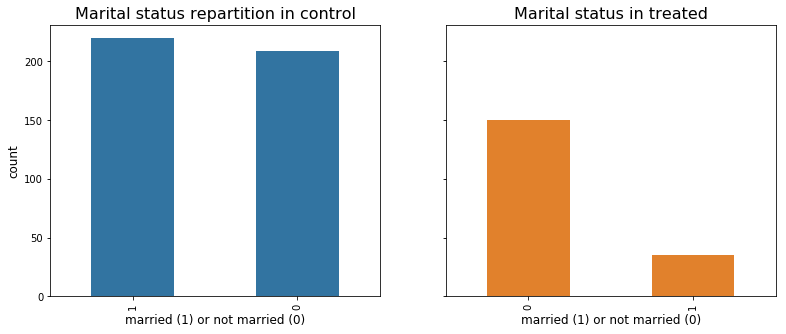

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(13,5))
valCountBar(grouped0['married'], "Marital status repartition in control", "married (1) or not married (0)", "count", ax1, 'b')
valCountBar(grouped1['married'], "Marital status in treated", "married (1) or not married (0)", "count", ax2, 'r')
plt.show()

We clearly observe that most of the people that followed the program were single while the proportion of married and single individuals in the control dataset is balanced.

*The fact that someone is married or not can also have an influence on its income and should be taken into account*

#### Degree

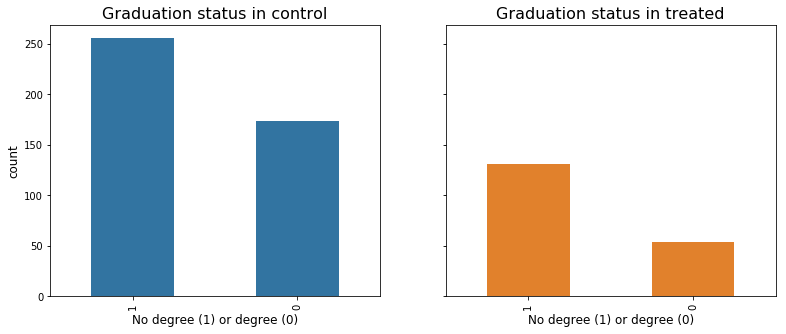

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(13,5))
valCountBar(grouped0['nodegree'], "Graduation status in control", "No degree (1) or degree (0)", "count", ax1, 'b')
valCountBar(grouped1['nodegree'], "Graduation status in treated", "No degree (1) or degree (0)", "count", ax2, 'r')
plt.show()

In this case, both groups exhibit the same repartition as about two-third of the people do not have a degree in each.

#### Real earnings in 1974 (pre-treatment)

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


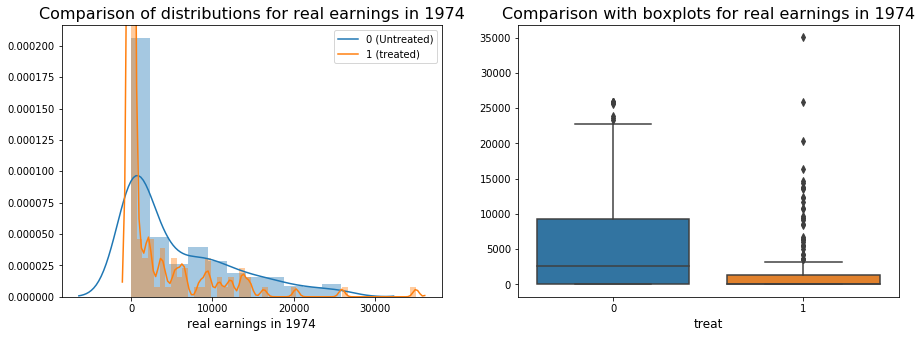

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))
densplot([grouped0["re74"],grouped1["re74"]], "real earnings in 1974", "Comparison of distributions for real earnings in 1974", ax1)
ax1.legend(["0 (Untreated)", "1 (treated)"])
boplot([grouped0["re74"],grouped1["re74"]],"Comparison with boxplots for real earnings in 1974", "treat", False, ax2)
plt.show()

We observe that both groups contain a lot of people with no income at this date. We also notice that more people that didn't participate in the program already had a salary at this date which is less the case for people that participated.

#### real earnings in 1975 (pre-treatment)

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


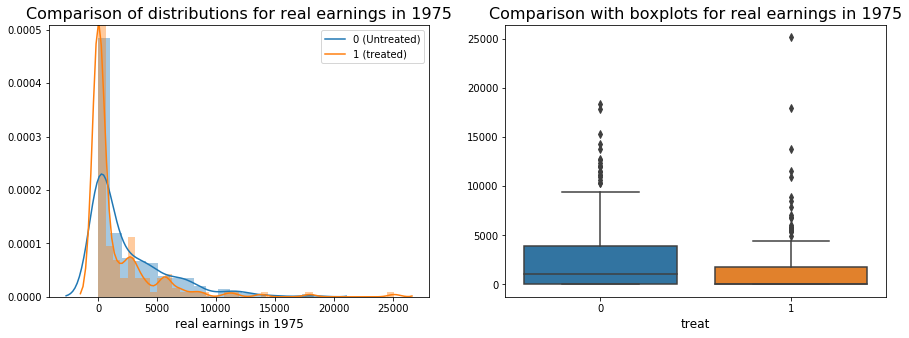

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))
densplot([grouped0["re75"],grouped1["re75"]], "real earnings in 1975", "Comparison of distributions for real earnings in 1975", ax1)
ax1.legend(["0 (Untreated)", "1 (treated)"])
boplot([grouped0["re75"],grouped1["re75"]],"Comparison with boxplots for real earnings in 1975", "treat", False, ax2)
plt.show()

We observe that the income decreased for a lot of people in the control group, while it increased for some in the treated one.

#### Conclusion

We discuss here our main observations and how they relate to our naive analysis.
- The control group contains more subjects above 30 years old,
- most of the treated subjects were single, which is not the case in the control group,
- compared to the control group, very few subjects in the treated group had a salary in 1974.

From these observations, we note that, even though the median values are often similar in both datasets, the distributions are different. Moreover, this is particularly the case for the age and race features which can both have a high impact on the income of a person.

### 3. A propensity score model

We use logistic regression to estimate propensity scores for all points in the dataset.

In [61]:
logistic = linear_model.LogisticRegression()
feature_cols = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

propensity = logistic.fit(data[feature_cols].values, data['treat'].values)

data['propensity'] = propensity.predict_proba(data[feature_cols].values)[:,1] # The predicted propensities by the model

### 4. Balancing the dataset via matching

We use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.

We start our matching process by creating the matrix of the costs (using the absolute difference between the propensity scores as a cost function) of all the possible assignments. We then use this matrix to solve the linear sum assignment problem (The linear sum assignment problem is also known as minimum weight matching in bipartite graphs).


In [17]:
group2 = data.groupby('treat')
group20 = group2.get_group(0).reset_index()
group21 = group2.get_group(1).reset_index()

def dist(a, b):
    return (a-b)*(a-b)

#costs = np.array([dist(, n) for n in group21["propensity"]])
costs = np.array([np.array([0.0]*len(group21["propensity"]))]*len(group20["propensity"]))


for i, p0 in enumerate(group20["propensity"]):
    for j, p1 in enumerate(group21["propensity"]):
        costs[i][j] = dist(p0, p1)
        

print("Computing optimal assigment... ", end="")
id_n1, id_n2 = linear_sum_assignment(costs)
sol_costs = costs[id_n1, id_n2]
print("Done: cost of solution = %f" % sol_costs.sum())

match = group21.loc[id_n2].reset_index(drop=True).join(group20.loc[id_n1].reset_index(drop=True), rsuffix="_notreat")
match["prop_diff"] = dist(match["propensity_notreat"],match["propensity"])

Computing optimal assigment... Done: cost of solution = 13.299964


#### Post-matching outcome variable analysis

We compare the outcomes (`re78`) between the treated and control groups 

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


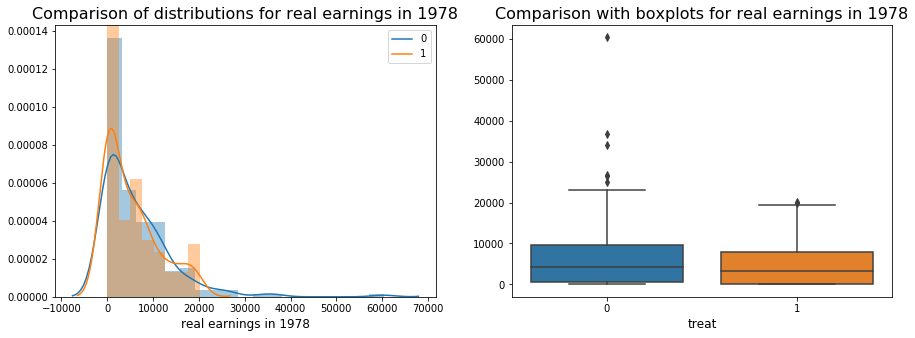

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))
densplot([match["re78"], match["re78_notreat"]], "real earnings in 1978", "Comparison of distributions for real earnings in 1978", ax1)
boplot([match["re78"], match["re78_notreat"]],"Comparison with boxplots for real earnings in 1978", "treat", "", False, ax2)
plt.show()

As we observed in the beginning, the two datasets have similar distributions even though the group of people that didn't follow the program are still more numerous to have big incomes.

We compare again the feature-value distributions between the two groups but now only for the matched subjects.
In this case, we start with all the features that are now well-balanced between the two datasets.

It is clearly the case for: `married`, `nodegree`, `educ`, `re74`, `re75`, for which we display only the figures that illustrate the improvement (more were indeed plotted when assessing it).

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


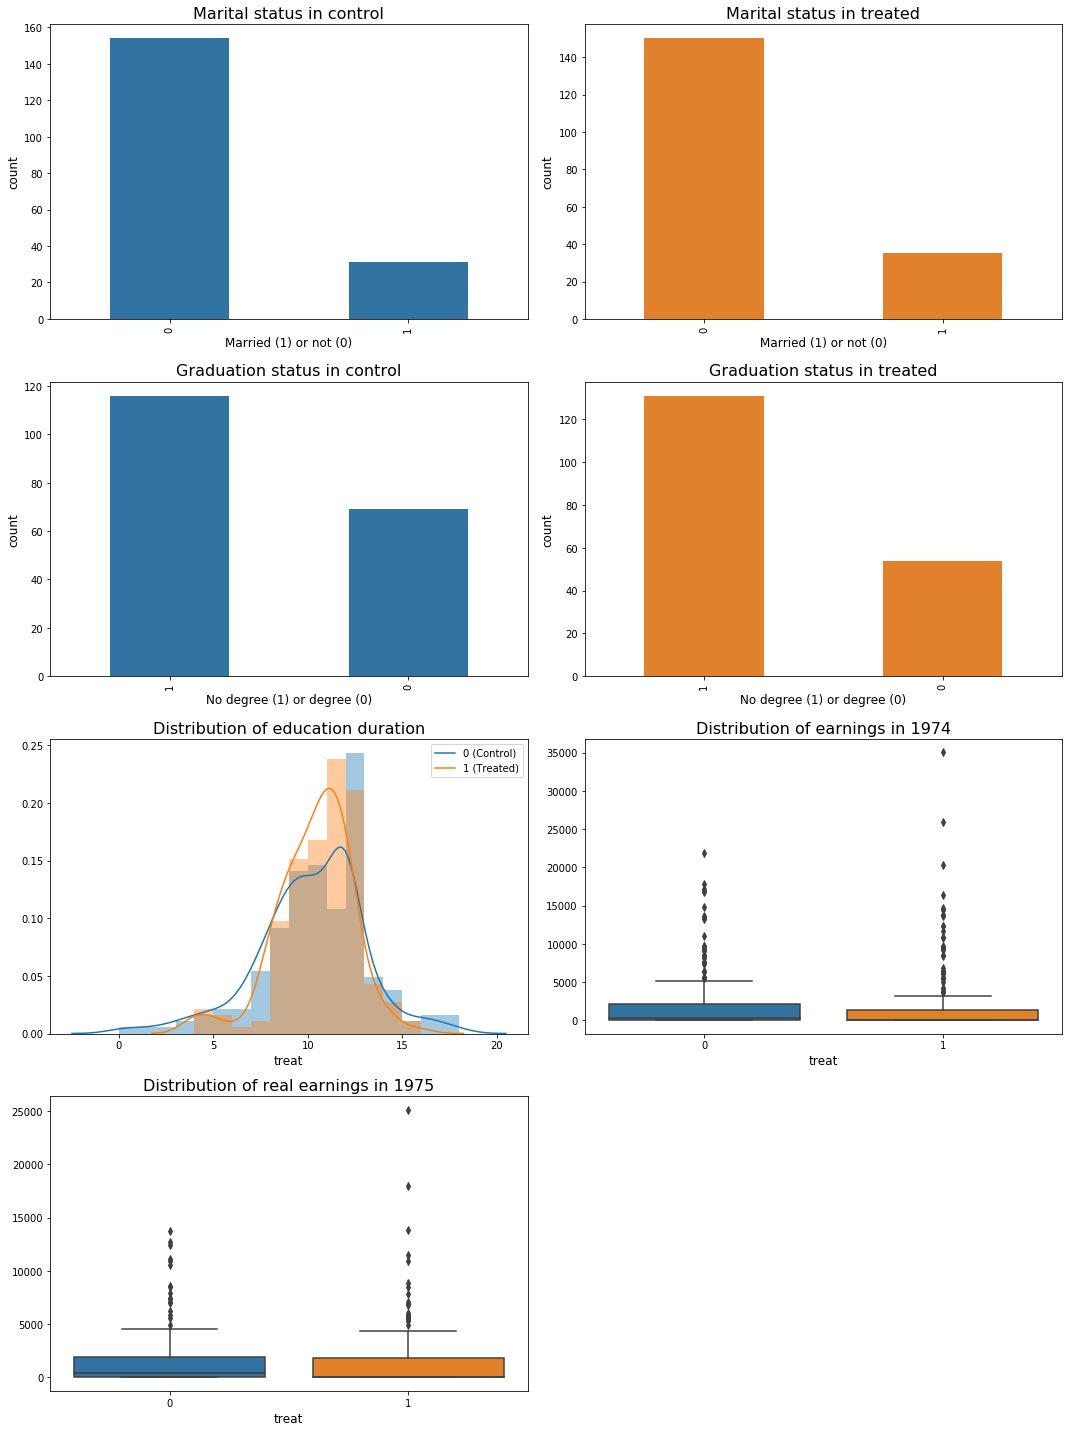

In [63]:
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(nrows=4, ncols=2, sharey=False, figsize=(15,20))
valCountBar(match['married_notreat'], "Marital status in control", "Married (1) or not (0)", "count", ax1, 'b')
valCountBar(match['married'], "Marital status in treated", "Married (1) or not (0)", "count", ax2, 'r')
valCountBar(match['nodegree_notreat'], "Graduation status in control", "No degree (1) or degree (0)", "count", ax3, 'b')
valCountBar(match['nodegree'], "Graduation status in treated", "No degree (1) or degree (0)", "count", ax4, 'r')
densplot([match["educ_notreat"],match["educ"]], "treat", "Distribution of education duration", ax5)
boplot([match["re74_notreat"],match["re74"]],"Distribution of earnings in 1974","treat","", False, ax6)
boplot([match["re75_notreat"],match["re75"]],"Distribution of real earnings in 1975", "treat","", False, ax7)
ax5.legend(["0 (Control)", "1 (Treated)"])
fig.delaxes(ax8)
fig.tight_layout()
plt.show()

Now, we analyse the features for which the distribution is still unsatisfactory.

#### Age

We observe that the matched subjects are mostly between 17 and 27 years old in the control group and between 20 and 28 in the treated one. We will come back to this feature if our next improved matching is still not good enough.

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


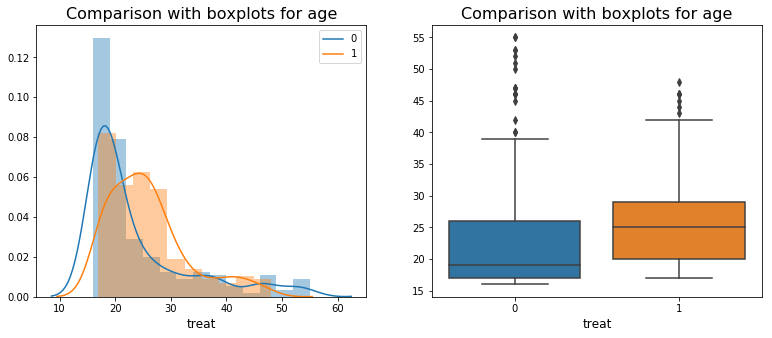

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(13,5))
densplot([match["age_notreat"], match["age"]], "treat", "Comparison with boxplots for age", ax1)
boplot([match["age_notreat"], match["age"]],"Comparison with boxplots for age", "treat", False, ax2)
plt.show()

#### Race

The race distributions are now closer, but still not matching.

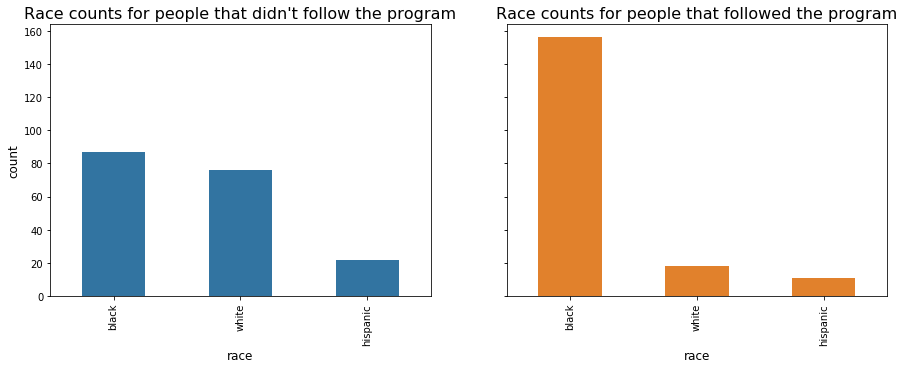

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
valCountBar(match['race_notreat'], "Race counts for people that didn't follow the program", "race", "count", ax1, 'b')
valCountBar(match['race'], "Race counts for people that followed the program", "race", "count", ax2, 'r')
plt.show()

**Are you closer to being able to draw valid conclusions now than you were before?**

We are closer than before as the dataset is well-balanced for multiple features. However, there are still three features for which the distribution is not satisfactorily matching. The worst one seems to be the race with the treated group containing almost only black people, while the control group is more balanced. 

### 5. Balancing the groups further

Since the race feature seems to be the most problematic one, we first try to solve this issue by keeping only the subjects matched with the same race, as it is suggested in the homework statement.

In [22]:
matchRace = match.loc[match['race'] == match['race_notreat']]
print("Dropping" , len(match) - len(matchRace), "out of", len(match),"subjects with unmatching race")

Dropping 80 out of 185 subjects with unmatching race


We vizualize the distribution in the subgroups using some plots we selected (again, more were vizualized).

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


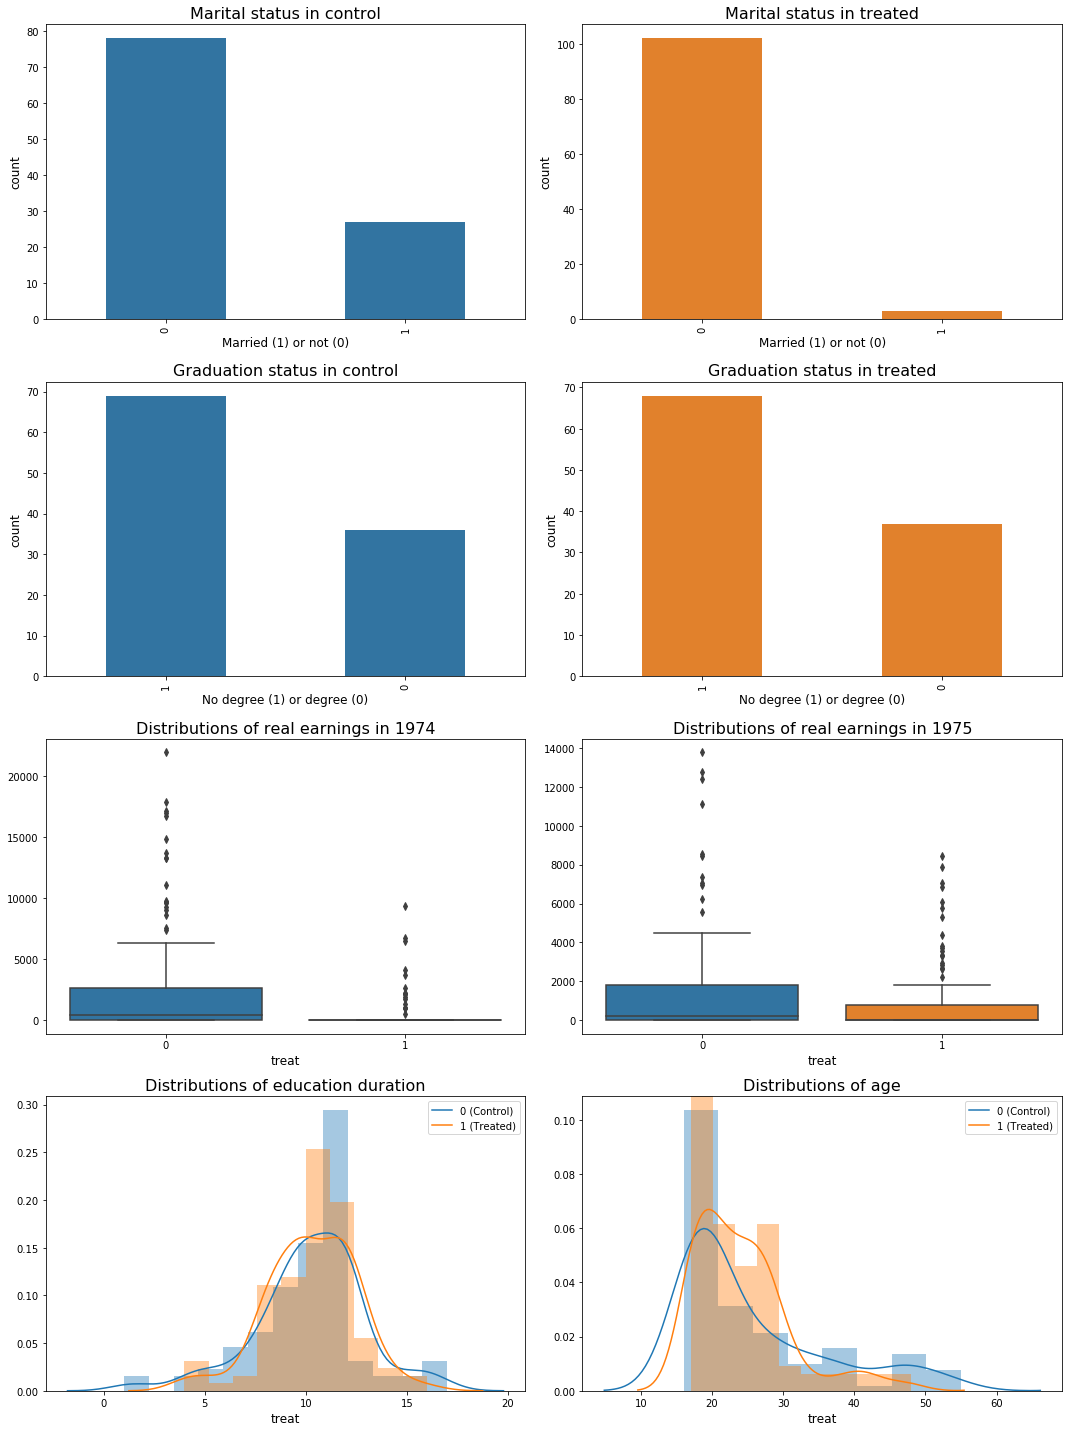

In [64]:
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(nrows=4, ncols=2, sharey=False, figsize=(15,20))
valCountBar(matchRace['married_notreat'], "Marital status in control", "Married (1) or not (0)", "count", ax1, 'b')
valCountBar(matchRace['married'], "Marital status in treated", "Married (1) or not (0)", "count", ax2, 'r')
valCountBar(matchRace['nodegree_notreat'], "Graduation status in control", "No degree (1) or degree (0)", "count", ax3, 'b')
valCountBar(matchRace['nodegree'], "Graduation status in treated", "No degree (1) or degree (0)", "count", ax4, 'r')
boplot([matchRace["re74_notreat"],matchRace["re74"]], "Distributions of real earnings in 1974","treat", "", False, ax5)
boplot([matchRace["re75_notreat"],matchRace["re75"]],"Distributions of real earnings in 1975", "treat", "", False,  ax6)
densplot([matchRace["educ_notreat"],matchRace["educ"]],"treat", "Distributions of education duration", ax7)
densplot([matchRace["age_notreat"], matchRace["age"]],"treat", "Distributions of age", ax8)
for ax in (ax7, ax8):
    ax.legend(["0 (Control)", "1 (Treated)"])
fig.tight_layout()
plt.show()

Three things are to be noticed at this point. First, we had to drop a lot of points (80 out of 185) to obtain a perfect race distribution matching. This is undesirable as it inherently make our conclusion statistically weaker. Secondly, by arbitrarily removing subjects, we transformed the dataset according to our personnal assumption (or prejudices) about the data: namely that the race distribution matching is more important than the other ones. Thus resulting in the third point: we have noticed again a significative distribution difference in the `married`, `re74` and `re75` features. We could try to solve this problem by again trying to balance these attributes explicitely, but its easy to see that we would quickly end up with very few points in our dataset.

To address these issues, we propose an arguably better solution to improve the matching, based exclusively on the propensity scores. It is based on the observation that the logistic regression already provided a way to quantify how good is a pairing, without assuming anything on the importance of the features: the propensity score distance.

We begin by showing the distribution of this variable:

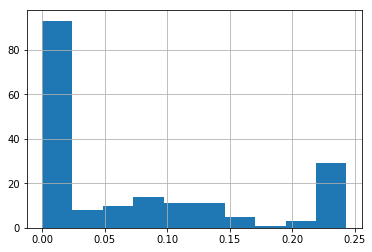

In [65]:
match["prop_diff"].hist()
plt.show()

We can see how most of the pairs can be matched with little score difference, while few of them are considered as bad pairing by the algorithm. Based on this observation, it is easy to set a threshold on the propensity score difference to exclude such pairs from the outcome variable analysis.

In [66]:
matchLess = match.loc[match['prop_diff'] < 0.16] # We set the threshold to get rid of the few most problematic points
print("Dropping" , len(match) - len(matchLess), "out of", len(match),"subjects with unmatching race")

Dropping 36 out of 185 subjects with unmatching race


Again, we vizualize the effect of this subject selection on the distribution of both control and treated groups:

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


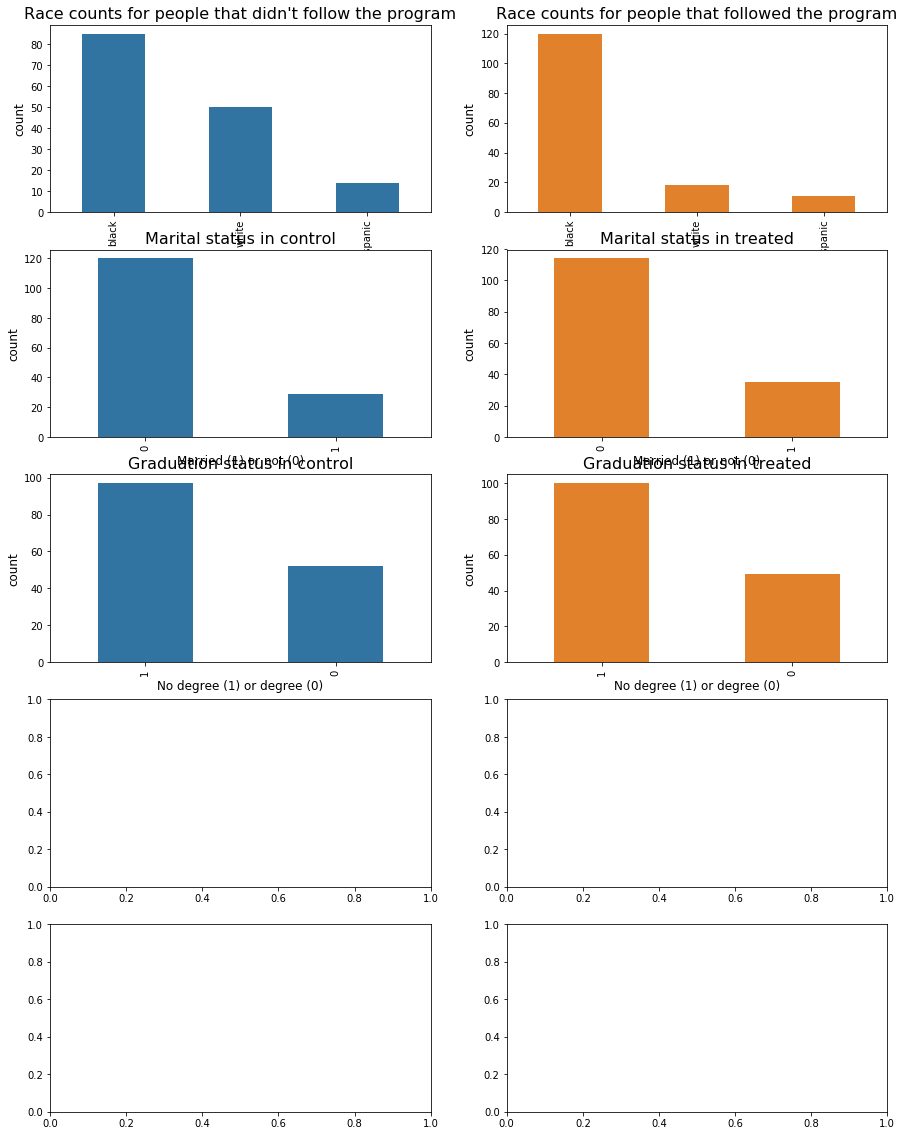

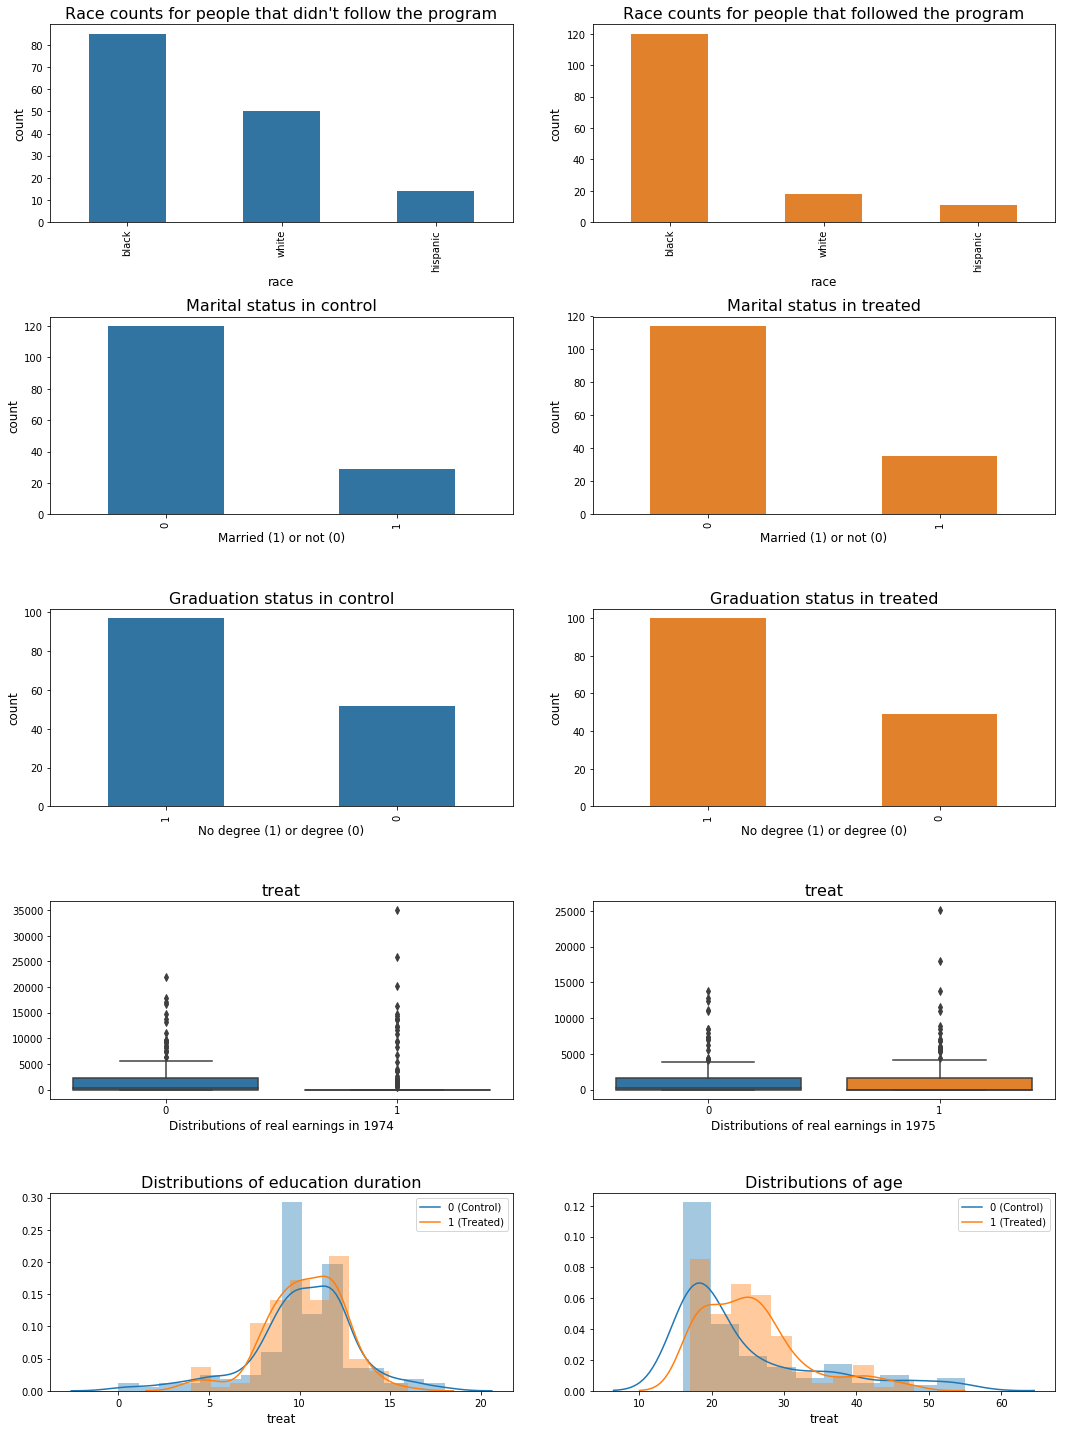

In [68]:
fig, ((ax01,ax02), (ax1, ax2), (ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(nrows=5, ncols=2, sharey=False, figsize=(15,20))

valCountBar(matchLess['race_notreat'], "Race counts for people that didn't follow the program", "race", "count", ax01, 'b')
valCountBar(matchLess['race'], "Race counts for people that followed the program", "race", "count", ax02, 'r')

valCountBar(matchLess['married_notreat'], "Marital status in control", "Married (1) or not (0)", "count", ax1, 'b')
valCountBar(matchLess['married'], "Marital status in treated", "Married (1) or not (0)", "count", ax2, 'r')
valCountBar(matchLess['nodegree_notreat'], "Graduation status in control", "No degree (1) or degree (0)", "count", ax3, 'b')
valCountBar(matchLess['nodegree'], "Graduation status in treated", "No degree (1) or degree (0)", "count", ax4, 'r')
boplot([matchLess["re74_notreat"],matchLess["re74"]],"treat", "Distributions of real earnings in 1974", "", False, ax5)
boplot([matchLess["re75_notreat"],matchLess["re75"]],"treat", "Distributions of real earnings in 1975", "",False, ax6)
densplot([matchLess["educ_notreat"],matchLess["educ"]],"treat", "Distributions of education duration", ax7)
densplot([matchLess["age_notreat"], matchLess["age"]],"treat", "Distributions of age", ax8)
for ax in (ax7, ax8):
    ax.legend(["0 (Control)", "1 (Treated)"])
fig.tight_layout()
plt.show()

We see that our method achieved a better **overall** similarity for the control and treated group distributions. As expected, by relaxing on the constraint to have a perfect matching of the `race` distribution, we gained statistical strenght by only throwing away 36 out of 185 points, while still enabling to bring both distributions closer toghether by tunable threshold. 

### 6. A less naive analysis

We can now proceed to the outcome variable analysis, using the subjects kept by our improved matching technique (i.e. based on propensity score only).

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


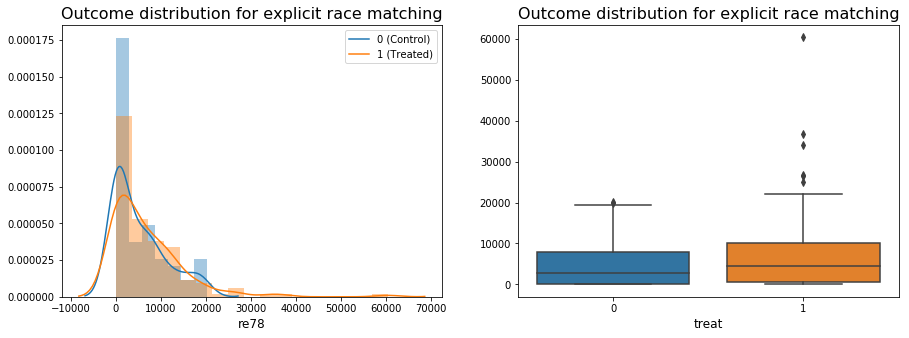

Average outcome salaries:
	 control: 5163.186447
	 treated: 6812.119842
Effect of treatment on the salary: 31.94 % higher on average.


In [69]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))
densplot([matchLess['re78_notreat'],matchLess['re78']],"re78", "Outcome distribution for explicit race matching", ax1)
ax1.legend(["0 (Control)", "1 (Treated)"])
boplot([matchLess['re78_notreat'],matchLess['re78']],"Outcome distribution for explicit race matching", "treat", "",False, ax2)
plt.show()

meanNoTreat =  matchLess['re78_notreat'].mean()
meanTreat = matchLess['re78'].mean()
print("Average outcome salaries:")
print("\t control: %f" % meanNoTreat)
print("\t treated: %f" % meanTreat)
effect = (meanTreat-meanNoTreat)/meanNoTreat
print("Effect of treatment on the salary: %.2f" %  (effect*100.0), "% higher on average." )

We observe that the treatment has indeed an effect on the outcome variable. We also note, without illustrating it, that the explicitely `race` matched dataset reaches more or less the same conclusion, even though it is weaker at demonstrating it due to the number of dropped points and to the greater overall inbalance between control and test group.

In [52]:
print(grouped0['re78'].head())

id
PSID1    25564.67
PSID2    25564.67
PSID3    25564.67
PSID4    15491.01
PSID5        0.00
Name: re78, dtype: float64


## Question 2: Applied ML

In [28]:
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.feature_extraction.text import CountVectorizer

In [70]:
SKIP_GRIDSEARCH = True # Set this to False may give work to your CPU

#### 1. Loading of dataset, TF-IDF, seperation of training, testing and validation sets
We load the 20newsgroup dataset using sklearn. Since we are going to create ourselves the traning, testing and validation datasets from the entire datasets, we load the entire newsgroup and not only the train subset as proposed in the tutorial. Also, we load the dataset without the metadata, namely without the headers, footers and quotes as it is recommended by the tutorial. That way, the data from texts can be studied without being masked by too frequent metadata such as the sender's affiliated university.

In [30]:
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
pprint(list(newsgroups.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


We use the TfidfVectorizer function to compute TF-IDF features for every article. 

In [31]:
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups.data)
# this allows us to have an idea of the number of words for which the TF-IDF is computed for the articles
print("%i articles \n%i TF-IDF features" % vectors.shape)
print("%.1f non-zero feature per article on average" % (vectors.nnz / float(vectors.shape[0])))

11314 articles 
101322 TF-IDF features
66.8 non-zero feature per article on average


It was not asked by the exercise but we notice that vectors are quite sparse looking at the above computation result.

We now split our dataset into a training (80%), a testing (10%) and a validation (10%) set. We use the train_test_split function and procede in two steps. First we seperate the whole set into the training set and a temporary set from which we then create the testing and validation sets. Each observation is paired with its corresponding label (the article category).

In [32]:
#We seperate the training dataset from the rest, as a result we obtain the TF-IDF vectors belonging 
#to the training vectors as well as their corresponding label, namely the nesgroups targets. 
#We choose to use random_state=None as it means it will use np.random thus the training set is picked randomly.
labels_training,\
labels_tmp,\
vectors_training,\
vectors_tmp= train_test_split(newsgroups.target, vectors, test_size=0.2, random_state=None)

#We now seperate the tmp set with corresponding labels randomly in half to obtain the testing and validation sets
labels_testing,\
labels_validation,\
vectors_testing,\
vectors_validation = train_test_split(labels_tmp, vectors_tmp, test_size=0.1, random_state=None)

#### 2. Training of random forest, fine tuning of predictor on validation set, model assessment and discussion

We train a random forest on our training set.

In [33]:
clf = RandomForestClassifier()

We perform a grid search to fine tune the n_estimators and max_depth parameters by finding the best classifier accuracy on the validation set.

In [34]:
def grid_search(n_estimators_list, max_depth_list):
    score=0
    final_depth=0
    final_estimator=0
    for depth in max_depth_list:
        for n_estim in n_estimators_list:
            classifier=RandomForestClassifier(max_depth=depth, n_estimators=n_estim, n_jobs=-1, random_state=None)
            classifier.fit(vectors_training, labels_training)
            prediction = classifier.predict(vectors_validation)
            scoring = metrics.accuracy_score(labels_validation, prediction)
            if scoring > score:
                score=scoring
                final_depth=depth
                final_estimator=n_estim
    return (score, final_depth, final_estimator)

In [35]:
SKIP_GRIDSEARCH or grid_search([50,100,200,500,1000,1500,2000,2500], [1,10,20,30])

True

According to our grid search, we should use the Random Forest classifier with max_depth=30 and n_estimators=2500. We therefore instanciate the corresponding classifier.

In [36]:
classifier=RandomForestClassifier(max_depth=30, n_estimators=2500, n_jobs=-1, random_state=None)
classifier.fit(vectors_training, labels_training)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
prediction = classifier.predict(vectors_testing)

We now compute a confusion matrix of our classification pipeline by using the proposed function available as an example on the scikit-learn website.

In [38]:
#function found on scikit-learn to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


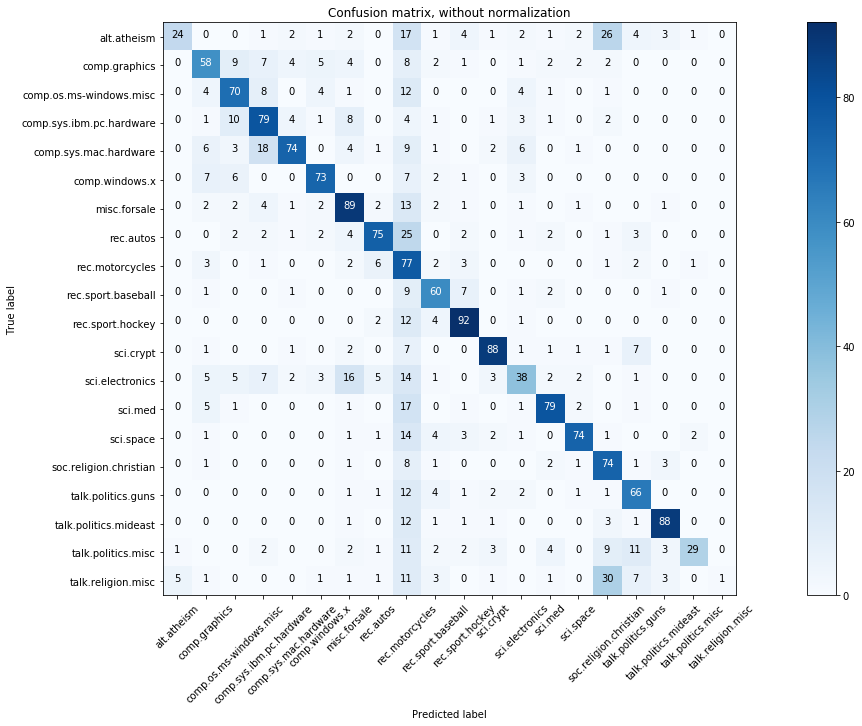

In [39]:
# Compute confusion matrix
confusion = confusion_matrix(labels_testing, prediction) 
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(confusion, classes=newsgroups.target_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix


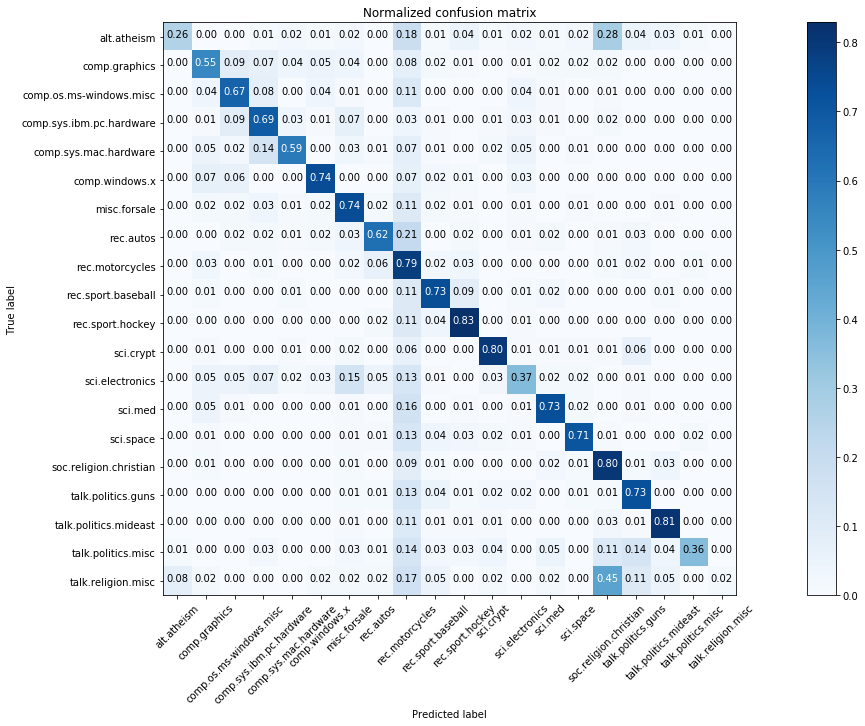

In [40]:
# Plot normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(confusion, classes=newsgroups.target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Just by looking at the color gradient of the confusion matrix, we notice that the diagonal elements are much higher than other elements who in fact are mostly equal to zero. This means that most of the data from the testing set corresponds to its prediction by our classifier. Hence our classifier seems to be working.

Finally, we inspect the `feature_importances_` attribute of our random forest and discuss the obtained results. We display in a horizontal histogram the feature importances of the 10 most important features.

In [41]:
sorted_index = np.argsort(classifier.feature_importances_)
best10 = sorted_index[-1:-11:-1]
features = np.array(vectorizer.get_feature_names())[best10]
importances = classifier.feature_importances_[best10]

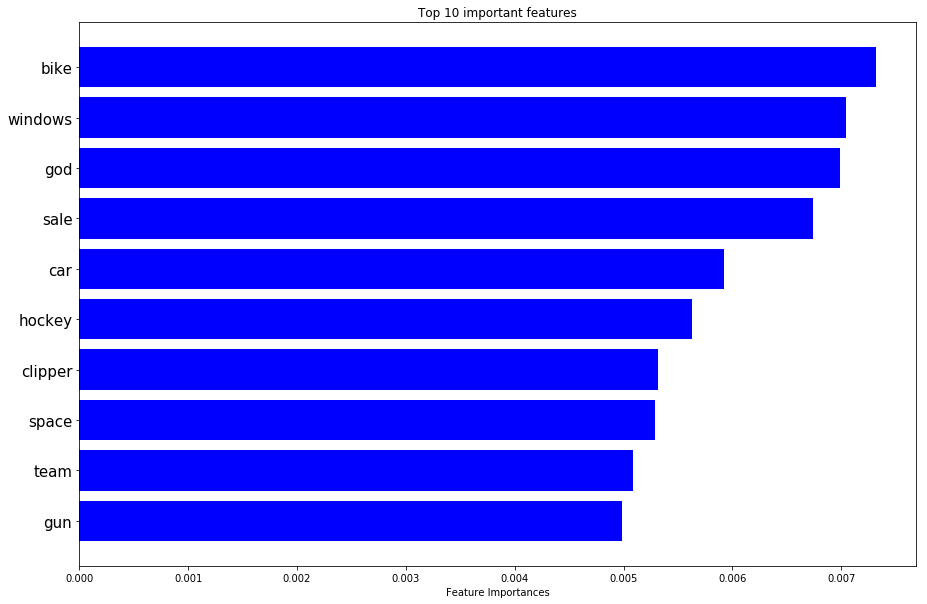

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
y_pos = np.arange(len(features))
ax.barh(y_pos, importances, align='center', color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(features, size = 15)
ax.invert_yaxis()  
ax.set_xlabel('Feature Importances')
ax.set_title('Top 10 important features')
plt.show()